In [1]:
def return_zero_for_div_by_zero(numerators, divisors):
    return [num / div if div != 0 else 0 for num, div in zip(numerators, divisors)]

In [2]:
import pandas as pd

# Define the data
data = {
    'Container': ['A', 'B', 'C'],
    'Arrivals': [0, 12, 24],
    'Departures': [36, 48, 72]
}

# Create a DataFrame
containers = pd.DataFrame(data)
containers['Dwell'] = containers['Departures'] - containers['Arrivals']

# Display the DataFrame
print(containers)

  Container  Arrivals  Departures  Dwell
0         A         0          36     36
1         B        12          48     36
2         C        24          72     48


In [3]:
# Event list 

event_list = pd.melt(containers, id_vars=['Container'], value_vars=['Arrivals', 'Departures'], 
                    var_name='Event Type', value_name='Time')
event_list = event_list.sort_values(by='Time', ascending=True)
event_list['Box_Count_Incr'] = event_list['Event Type'].apply(lambda x: 1 if x == 'Arrivals' else -1)
event_list['Box_Count'] = event_list['Box_Count_Incr'].cumsum()
event_list['Next Container'] = event_list['Container'].shift(-1)
event_list['Next Event Type'] = event_list['Event Type'].shift(-1)
event_list['Next Event Time'] = event_list['Time'].shift(-1)
event_list['Duration'] = event_list['Next Event Time'] - event_list['Time']

In [4]:
print(event_list)

  Container  Event Type  Time  Box_Count_Incr  Box_Count Next Container  \
0         A    Arrivals     0               1          1              B   
1         B    Arrivals    12               1          2              C   
2         C    Arrivals    24               1          3              A   
3         A  Departures    36              -1          2              B   
4         B  Departures    48              -1          1              C   
5         C  Departures    72              -1          0           None   

  Next Event Type  Next Event Time  Duration  
0        Arrivals             12.0      12.0  
1        Arrivals             24.0      12.0  
2      Departures             36.0      12.0  
3      Departures             48.0      12.0  
4      Departures             72.0      24.0  
5            None              NaN       NaN  


In [5]:
intervals = event_list.copy()
intervals = intervals.dropna(subset=['Next Container']).copy()
intervals['Dwell Rise'] = intervals['Duration'] * intervals['Box_Count']
intervals = pd.merge(intervals, containers, on='Container', how='inner')
intervals['Dwell Loss'] = intervals.apply(lambda row: -1 * row['Dwell'] if row['Event Type'] == 'Departures' else 0, axis=1)
intervals['Dwell Incr'] = intervals['Dwell Rise'] + intervals['Dwell Loss']
intervals['Ending Dwell'] = intervals['Dwell Incr'].cumsum()
intervals['Starting Dwell'] = intervals['Ending Dwell'] - intervals['Dwell Rise']
intervals['Starting Avg Dwell'] = intervals['Starting Dwell'] / intervals['Box_Count']
intervals['Ending Avg Dwell'] = intervals['Ending Dwell'] / intervals['Box_Count']

In [6]:
print(intervals)

  Container  Event Type  Time  Box_Count_Incr  Box_Count Next Container  \
0         A    Arrivals     0               1          1              B   
1         B    Arrivals    12               1          2              C   
2         C    Arrivals    24               1          3              A   
3         A  Departures    36              -1          2              B   
4         B  Departures    48              -1          1              C   

  Next Event Type  Next Event Time  Duration  Dwell Rise  Arrivals  \
0        Arrivals             12.0      12.0        12.0         0   
1        Arrivals             24.0      12.0        24.0        12   
2      Departures             36.0      12.0        36.0        24   
3      Departures             48.0      12.0        24.0         0   
4      Departures             72.0      24.0        24.0        12   

   Departures  Dwell  Dwell Loss  Dwell Incr  Ending Dwell  Starting Dwell  \
0          36     36           0        12.0      

In [7]:
avg_dwell_segments = intervals.copy()
avg_dwell_segments = avg_dwell_segments.drop(columns=[
                        'Container','Event Type','Box_Count_Incr','Box_Count'
                        ,'Next Container','Next Event Type','Duration','Dwell Rise'
                        ,'Arrivals','Departures','Dwell','Dwell Loss'
                        ,'Dwell Incr','Starting Dwell','Ending Dwell'])

In [8]:
print(avg_dwell_segments)

   Time  Next Event Time  Starting Avg Dwell  Ending Avg Dwell
0     0             12.0                 0.0              12.0
1    12             24.0                 6.0              18.0
2    24             36.0                12.0              24.0
3    36             48.0                18.0              30.0
4    48             72.0                24.0              48.0


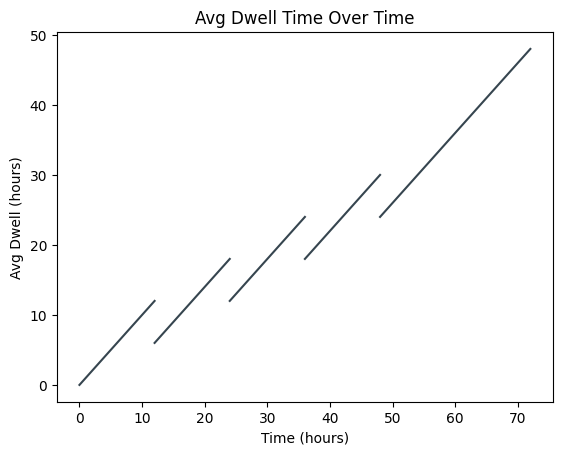

In [9]:
import matplotlib.pyplot as plt

# Plot the line segments for the avg dwell
for i in range(len(avg_dwell_segments)):
    plt.plot([avg_dwell_segments.loc[i, 'Time'], avg_dwell_segments.loc[i, 'Next Event Time']]
              , [avg_dwell_segments.loc[i, 'Starting Avg Dwell'], avg_dwell_segments.loc[i, 'Ending Avg Dwell']]
             , color='#36454F')

"""
# Fill the area under the curve with rectangles and triangles
plt.fill_between([avg_dwell_segments.loc[i, 'Time'], avg_dwell_segments.loc[i, 'Next Event Time']],
                 [avg_dwell_segments.loc[i, 'Starting Avg Dwell'], avg_dwell_segments.loc[i, 'Ending Avg Dwell']],
                 color='#36454F', alpha=0.3)
"""

# Display the plot
plt.xlabel('Time (hours)')
plt.ylabel('Avg Dwell (hours)')
plt.title('Avg Dwell Time Over Time')
plt.show()

In [10]:
dwell_segments = intervals.copy()
dwell_segments = dwell_segments.drop(columns=[
                        'Container','Event Type','Box_Count_Incr','Box_Count'
                        ,'Next Container','Next Event Type','Duration','Dwell Rise'
                        ,'Arrivals','Departures','Dwell','Dwell Loss'
                        ,'Dwell Incr','Starting Avg Dwell','Ending Avg Dwell'])

In [11]:
print(dwell_segments)

   Time  Next Event Time  Ending Dwell  Starting Dwell
0     0             12.0          12.0             0.0
1    12             24.0          36.0            12.0
2    24             36.0          72.0            36.0
3    36             48.0          60.0            36.0
4    48             72.0          48.0            24.0


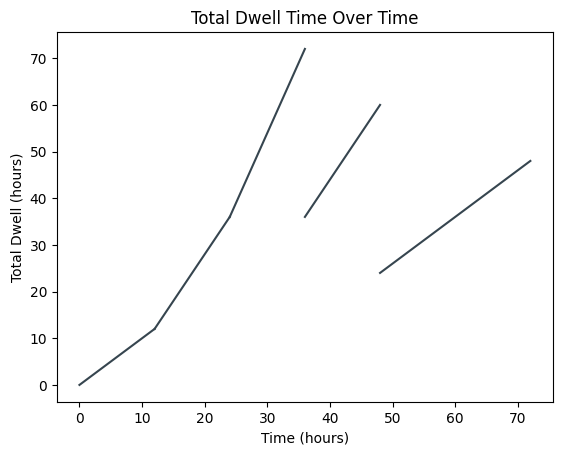

In [12]:
# Plot the line segments for the total dwell
for i in range(len(dwell_segments)):
    plt.plot([dwell_segments.loc[i, 'Time'], dwell_segments.loc[i, 'Next Event Time']]
              , [dwell_segments.loc[i, 'Starting Dwell'], dwell_segments.loc[i, 'Ending Dwell']]
             , color='#36454F')

# Display the plot
plt.xlabel('Time (hours)')
plt.ylabel('Total Dwell (hours)')
plt.title('Total Dwell Time Over Time')
plt.show()

In [13]:
box_count_segments = intervals.copy()
box_count_segments = box_count_segments.drop(columns=[
                        'Container','Event Type','Box_Count_Incr'
                        ,'Next Container','Next Event Type','Duration','Dwell Rise'
                        ,'Arrivals','Departures','Dwell','Dwell Loss'
                        ,'Dwell Incr','Ending Dwell','Starting Dwell','Starting Avg Dwell','Ending Avg Dwell'])

In [14]:
print(box_count_segments)

   Time  Box_Count  Next Event Time
0     0          1             12.0
1    12          2             24.0
2    24          3             36.0
3    36          2             48.0
4    48          1             72.0


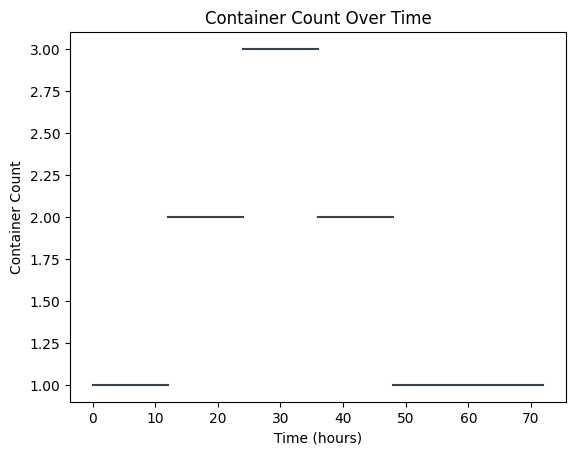

In [15]:
# Plot the line segments for the box count
for i in range(len(box_count_segments)):
    plt.plot([box_count_segments.loc[i, 'Time'], box_count_segments.loc[i, 'Next Event Time']]
              , [box_count_segments.loc[i, 'Box_Count'], box_count_segments.loc[i, 'Box_Count']]
             , color='#36454F')

# Display the plot
plt.xlabel('Time (hours)')
plt.ylabel('Container Count')
plt.title('Container Count Over Time')
plt.show()

In [16]:
# Creating the sampling points
import numpy as np

sample_interval = 12 # in hours
sample_offset = sample_interval / 2
start_time = containers['Arrivals'].min()
end_time = containers['Departures'].max()
period = end_time - start_time
sampling_times = list(np.arange(start_time, end_time + sample_interval, sample_interval))
sampling_times = [time + sample_offset for time in sampling_times]
sampling_df = pd.DataFrame(sampling_times, columns=['SamplingTime'])
sampling_df = pd.merge(sampling_df.assign(key=1), avg_dwell_segments.assign(key=1), on='key').query('Time <= SamplingTime <= `Next Event Time`').drop('key', axis=1)
sampling_df['SampleDwell'] = sampling_df['Starting Avg Dwell'] + sampling_df['SamplingTime'] - sampling_df['Time']
sampling_df = sampling_df.sort_values(by=['SamplingTime', 'Time'], ascending=[True, True])
sampling_df = sampling_df.drop(columns=['Time', 'Next Event Time', 'Starting Avg Dwell', 'Ending Avg Dwell'])
sampling_df = sampling_df.drop_duplicates(subset='SamplingTime')

In [17]:
#print(start_time)
#print(end_time)
#print(sampling_df)
print(sampling_df)

    SamplingTime  SampleDwell
0            6.0          6.0
6           18.0         12.0
12          30.0         18.0
18          42.0         24.0
24          54.0         30.0
29          66.0         42.0


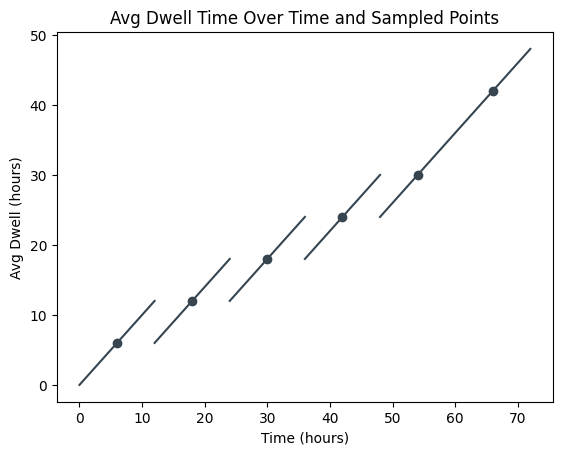

In [18]:
import matplotlib.pyplot as plt

# Plot the line segments for the avg dwell
for i in range(len(avg_dwell_segments)):
    plt.plot([avg_dwell_segments.loc[i, 'Time'], avg_dwell_segments.loc[i, 'Next Event Time']]
              , [avg_dwell_segments.loc[i, 'Starting Avg Dwell'], avg_dwell_segments.loc[i, 'Ending Avg Dwell']]
             , color='#36454F')

# Overlay the sampling points
plt.scatter(sampling_df['SamplingTime'], sampling_df['SampleDwell'], color='#36454F', label='Sampling Points')

# Display the plot
plt.xlabel('Time (hours)')
plt.ylabel('Avg Dwell (hours)')
plt.title('Avg Dwell Time Over Time and Sampled Points')
plt.show()

In [19]:
print(intervals)

  Container  Event Type  Time  Box_Count_Incr  Box_Count Next Container  \
0         A    Arrivals     0               1          1              B   
1         B    Arrivals    12               1          2              C   
2         C    Arrivals    24               1          3              A   
3         A  Departures    36              -1          2              B   
4         B  Departures    48              -1          1              C   

  Next Event Type  Next Event Time  Duration  Dwell Rise  Arrivals  \
0        Arrivals             12.0      12.0        12.0         0   
1        Arrivals             24.0      12.0        24.0        12   
2      Departures             36.0      12.0        36.0        24   
3      Departures             48.0      12.0        24.0         0   
4      Departures             72.0      24.0        24.0        12   

   Departures  Dwell  Dwell Loss  Dwell Incr  Ending Dwell  Starting Dwell  \
0          36     36           0        12.0      

In [20]:
intervals['Areas'] = intervals['Starting Avg Dwell'] * intervals['Duration'] + 0.5 * (intervals['Duration'] ** 2)
integration_result = intervals['Areas'].sum() / period

In [21]:
print(intervals)

  Container  Event Type  Time  Box_Count_Incr  Box_Count Next Container  \
0         A    Arrivals     0               1          1              B   
1         B    Arrivals    12               1          2              C   
2         C    Arrivals    24               1          3              A   
3         A  Departures    36              -1          2              B   
4         B  Departures    48              -1          1              C   

  Next Event Type  Next Event Time  Duration  Dwell Rise  Arrivals  \
0        Arrivals             12.0      12.0        12.0         0   
1        Arrivals             24.0      12.0        24.0        12   
2      Departures             36.0      12.0        36.0        24   
3      Departures             48.0      12.0        24.0         0   
4      Departures             72.0      24.0        24.0        12   

   Departures  Dwell  Dwell Loss  Dwell Incr  Ending Dwell  Starting Dwell  \
0          36     36           0        12.0      

In [22]:
print(integration_result)

22.0


In [23]:
sampling_result = sampling_df['SampleDwell'].mean()

In [24]:
print(sampling_result)

22.0


In [25]:
containers['DwellAreas'] = 0.5 * ((containers['Departures'] - containers['Arrivals']) ** 2)

In [26]:
print(containers)

  Container  Arrivals  Departures  Dwell  DwellAreas
0         A         0          36     36       648.0
1         B        12          48     36       648.0
2         C        24          72     48      1152.0


In [27]:
containers['BoxCountAreas'] = containers['Departures'] - containers['Arrivals']

In [28]:
print(containers)

  Container  Arrivals  Departures  Dwell  DwellAreas  BoxCountAreas
0         A         0          36     36       648.0             36
1         B        12          48     36       648.0             36
2         C        24          72     48      1152.0             48


In [29]:
ratio_result = containers['DwellAreas'].sum() / containers['BoxCountAreas'].sum()

In [30]:
print(ratio_result)

20.4


In [31]:
mainsail_result = (containers['Departures'].sum() - containers['Arrivals'].sum())/containers.shape[0]

In [32]:
print(mainsail_result)

40.0


In [33]:
event_list_days = pd.melt(containers, id_vars=['Container'], value_vars=['Arrivals', 'Departures'], 
                    var_name='Event Type', value_name='Time')

last_day = end_time // 24
first_day = start_time // 24
num_days = last_day - first_day 
days = list(range(first_day + 1, last_day + 1))
new_events = pd.DataFrame({
    'Container': [None for _ in range(num_days)],
    'Event Type': ['Day Change' for _ in range(num_days)],
    'Time': [(_ + 1) * 24 for _ in range(num_days)]
})

event_list_days = pd.concat([event_list_days, new_events], ignore_index=True)
event_list_days = event_list_days.sort_values(by='Time', ascending=True)
event_list_days['Box_Count_Incr'] = event_list_days['Event Type'].apply(lambda x: 1 if x == 'Arrivals' else -1 if x == 'Departures' else 0)
event_list_days['Box_Count'] = event_list_days['Box_Count_Incr'].cumsum()
event_list_days['Next Container'] = event_list_days['Container'].shift(-1)
event_list_days['Next Event Type'] = event_list_days['Event Type'].shift(-1)
event_list_days['Next Event Time'] = event_list_days['Time'].shift(-1)
event_list_days['Duration'] = event_list_days['Next Event Time'] - event_list_days['Time']

In [34]:
print(event_list_days)

  Container  Event Type  Time  Box_Count_Incr  Box_Count Next Container  \
0         A    Arrivals     0               1          1              B   
1         B    Arrivals    12               1          2              C   
2         C    Arrivals    24               1          3           None   
6      None  Day Change    24               0          3              A   
3         A  Departures    36              -1          2              B   
4         B  Departures    48              -1          1           None   
7      None  Day Change    48               0          1              C   
5         C  Departures    72              -1          0           None   
8      None  Day Change    72               0          0           None   

  Next Event Type  Next Event Time  Duration  
0        Arrivals             12.0      12.0  
1        Arrivals             24.0      12.0  
2      Day Change             24.0       0.0  
6      Departures             36.0      12.0  
3      Departu

In [35]:
intervals = event_list_days.copy()
intervals = intervals.dropna(subset=['Next Event Time']).copy()
intervals['Dwell Rise'] = intervals['Duration'] * intervals['Box_Count']
intervals = pd.merge(intervals, containers, on='Container', how='left')
intervals['Dwell Loss'] = intervals.apply(lambda row: -1 * row['Dwell'] if row['Event Type'] == 'Departures' else 0, axis=1)
intervals['Dwell Incr'] = intervals['Dwell Rise'] + intervals['Dwell Loss']
intervals['Ending Dwell'] = intervals['Dwell Incr'].cumsum()
intervals['Starting Dwell'] = intervals['Ending Dwell'] - intervals['Dwell Rise']
intervals['Starting Avg Dwell'] = return_zero_for_div_by_zero(intervals['Starting Dwell'], intervals['Box_Count'])
intervals['Ending Avg Dwell'] = return_zero_for_div_by_zero(intervals['Ending Dwell'], intervals['Box_Count'])
intervals['Areas'] = intervals['Starting Avg Dwell'] * intervals['Duration'] + 0.5 * (intervals['Duration'] ** 2)
intervals['Day'] = (intervals['Time'] // 24) + 1

In [36]:
print(intervals)

  Container  Event Type  Time  Box_Count_Incr  Box_Count Next Container  \
0         A    Arrivals     0               1          1              B   
1         B    Arrivals    12               1          2              C   
2         C    Arrivals    24               1          3           None   
3      None  Day Change    24               0          3              A   
4         A  Departures    36              -1          2              B   
5         B  Departures    48              -1          1           None   
6      None  Day Change    48               0          1              C   
7         C  Departures    72              -1          0           None   

  Next Event Type  Next Event Time  Duration  Dwell Rise  ...  DwellAreas  \
0        Arrivals             12.0      12.0        12.0  ...       648.0   
1        Arrivals             24.0      12.0        24.0  ...       648.0   
2      Day Change             24.0       0.0         0.0  ...      1152.0   
3      Departure

In [37]:
integration_result = intervals['Areas'].sum() / period
print(integration_result)

22.0


In [38]:
daily_integration_results = intervals.groupby('Day').agg({'Areas': 'sum', 'Duration': 'sum', 'Time': 'count'}).reset_index()
daily_integration_results = daily_integration_results.rename(columns={
    'Areas': 'Total_Areas',
    'Duration': 'Total_Duration',
    'Time': 'Record_Count'
})
daily_integration_results = daily_integration_results[
    ~((daily_integration_results['Total_Duration'] == 0.0) & (daily_integration_results['Record_Count'] == 1))
]
daily_integration_results['avg dwell'] = daily_integration_results['Total_Areas'] / 24

In [39]:
print(daily_integration_results)

   Day  Total_Areas  Total_Duration  Record_Count  avg dwell
0    1        216.0            24.0             2        9.0
1    2        504.0            24.0             3       21.0
2    3        864.0            24.0             2       36.0


In [40]:
integration_check = daily_integration_results['avg dwell'].mean()

In [41]:
print(integration_check)

22.0


In [42]:
daily_ratio_results = daily_integration_results[['Day']]
daily_ratio_results = daily_ratio_results.merge(containers, how='cross')
daily_ratio_results = daily_ratio_results.drop(columns=['Dwell', 'DwellAreas', 'BoxCountAreas'])
daily_ratio_results['Start_of_day'] = (daily_ratio_results['Day'] - 1) * 24
daily_ratio_results = daily_ratio_results[daily_ratio_results['Departures'] > daily_ratio_results['Start_of_day']]
daily_ratio_results['End_of_day'] = daily_ratio_results['Day'] * 24
daily_ratio_results = daily_ratio_results[daily_ratio_results['Arrivals'] < daily_ratio_results['End_of_day']]
daily_ratio_results['Daily_dwell_start'] = np.maximum(daily_ratio_results['Arrivals'], daily_ratio_results['Start_of_day'])
daily_ratio_results['Daily_dwell_end'] = np.minimum(daily_ratio_results['Departures'], daily_ratio_results['End_of_day'])
daily_ratio_results['Daily_dwell_rise'] = daily_ratio_results['Daily_dwell_end'] - daily_ratio_results['Daily_dwell_start']
daily_ratio_results['Daily_dwell_final'] = daily_ratio_results.sort_values('Day').groupby('Container')['Daily_dwell_rise'].cumsum()
daily_ratio_results['Daily_dwell_begin'] = daily_ratio_results['Daily_dwell_final'] - daily_ratio_results['Daily_dwell_rise']
daily_ratio_results['Daily_avg_dwell'] = (daily_ratio_results['Daily_dwell_final'] + daily_ratio_results['Daily_dwell_begin'])/2
daily_ratio_results['Avg_dwell_term'] = daily_ratio_results['Daily_avg_dwell'] * daily_ratio_results['Daily_dwell_rise'] / 24.0
daily_ratio_results['Avg_box_count_term'] = daily_ratio_results['Daily_dwell_rise'] / 24.0
grouped_sum = daily_ratio_results.groupby('Day')[['Avg_dwell_term', 'Avg_box_count_term']].sum()
grouped_sum['Division'] = grouped_sum['Avg_dwell_term'] / grouped_sum['Avg_box_count_term']

In [43]:
print(daily_ratio_results)
print(grouped_sum)
print(grouped_sum['Division'].mean())

   Day Container  Arrivals  Departures  Start_of_day  End_of_day  \
0    1         A         0          36             0          24   
1    1         B        12          48             0          24   
3    2         A         0          36            24          48   
4    2         B        12          48            24          48   
5    2         C        24          72            24          48   
8    3         C        24          72            48          72   

   Daily_dwell_start  Daily_dwell_end  Daily_dwell_rise  Daily_dwell_final  \
0                  0               24                24                 24   
1                 12               24                12                 12   
3                 24               36                12                 36   
4                 24               48                24                 36   
5                 24               48                24                 24   
8                 48               72                24

In [44]:
print(sampling_df)

    SamplingTime  SampleDwell
0            6.0          6.0
6           18.0         12.0
12          30.0         18.0
18          42.0         24.0
24          54.0         30.0
29          66.0         42.0


In [45]:
print(days)

[1, 2, 3]


In [46]:
day_end_times = [day * 24.0 for day in days]

In [47]:
print(day_end_times)

[24.0, 48.0, 72.0]


In [48]:
sampling_df = sampling_df.reset_index()

In [49]:
sampling_df = sampling_df.drop(columns=['index'])

In [50]:
sampling_df['DayIndex'] = sampling_df['SamplingTime'].apply(lambda x: int(x / 24.0) + 1)
sampling_df['TranslatedTime'] = sampling_df['SamplingTime'] - sampling_df['DayIndex'] * 24.0
sampling_df['TranslatedQuotient'] = sampling_df['TranslatedTime'].apply(lambda x: int(x / 24.0))
sampling_df['Day'] = sampling_df['DayIndex'] + sampling_df['TranslatedQuotient']
sampling_df['Day'] = sampling_df['Day'].apply(lambda x: max(x, 1))

In [51]:
print(sampling_df)

   SamplingTime  SampleDwell  DayIndex  TranslatedTime  TranslatedQuotient  \
0           6.0          6.0         1           -18.0                   0   
1          18.0         12.0         1            -6.0                   0   
2          30.0         18.0         2           -18.0                   0   
3          42.0         24.0         2            -6.0                   0   
4          54.0         30.0         3           -18.0                   0   
5          66.0         42.0         3            -6.0                   0   

   Day  
0    1  
1    1  
2    2  
3    2  
4    3  
5    3  


In [52]:
daily_sampling_results = sampling_df.groupby('Day')['SampleDwell'].mean().reset_index()
daily_sampling_results = daily_sampling_results.rename(columns={
    'SampleDwell': 'Avg Dwell'
})

In [53]:
print(daily_sampling_results)

   Day  Avg Dwell
0    1        9.0
1    2       21.0
2    3       36.0


In [54]:
print(daily_sampling_results['Avg Dwell'].mean())

22.0


So far, I've computed the average dwell time over the period using integration, sampling, the ratio method, and the Mainsail metric. I've also computed daily averages for the integration method, for sampling, and for the ratio method and compared those to the values for the entire period.

What's next is to compute daily averages for the Mainsail metric and compare those to the values for the entire period.

Then I need to pull all of the above into a function that takes the dataframe of arrivals and departures and a sampling frequency.

Then I need to set the notebook up to ingest TOS data.

In [55]:
mainsail_daily_results = daily_integration_results.copy()
mainsail_daily_results = mainsail_daily_results.drop(['Total_Areas', 'Total_Duration', 'Record_Count', 'avg dwell'], axis=1)
mainsail_daily_results = mainsail_daily_results.merge(containers, how='cross')
mainsail_daily_results['Day_start'] = (mainsail_daily_results['Day'] - 1) * 24
mainsail_daily_results['Day_end'] = mainsail_daily_results['Day'] * 24
mainsail_daily_results = mainsail_daily_results[(mainsail_daily_results['Arrivals'] >= mainsail_daily_results['Day_start']) & (mainsail_daily_results['Departures'] <= mainsail_daily_results['Day_end'])]

In [56]:
print(mainsail_daily_results)

Empty DataFrame
Columns: [Day, Container, Arrivals, Departures, Dwell, DwellAreas, BoxCountAreas, Day_start, Day_end]
Index: []


In [63]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [338]:
def dwell_times(container_times, sampling_interval):

    def plot_segments(segments, x1, x2, y1, y2, xTitle, yTitle, plotTitle, color, show):
        # Create the plot object
        for i in range(len(segments)):
            plt.plot([segments.loc[i, x1], segments.loc[i, x2]]
                      , [segments.loc[i, y1], segments.loc[i, y2]]
                     , color=color)
        
        # Display the plot
        plt.xlabel(xTitle)
        plt.ylabel(yTitle)
        plt.title(plotTitle)
        if show:
            plt.show()
        return plt

    def return_zero_for_div_by_zero(numerators, divisors):
        return [num / div if div != 0 else 0 for num, div in zip(numerators, divisors)]
    
    container_times['Dwell'] = container_times['Departures'] - container_times['Arrivals']

    # Event list 
    event_list = pd.melt(container_times, id_vars=['Container'], value_vars=['Arrivals', 'Departures'], 
                        var_name='Event Type', value_name='Time')
    event_list = event_list.sort_values(by='Time', ascending=True)
    event_list['Box_Count_Incr'] = event_list['Event Type'].apply(lambda x: 1 if x == 'Arrivals' else -1)
    event_list['Box_Count'] = event_list['Box_Count_Incr'].cumsum()
    event_list['Next Container'] = event_list['Container'].shift(-1)
    event_list['Next Event Type'] = event_list['Event Type'].shift(-1)
    event_list['Next Event Time'] = event_list['Time'].shift(-1)
    event_list['Duration'] = event_list['Next Event Time'] - event_list['Time']

    # Intervals
    intervals = event_list.copy()
    intervals = intervals.dropna(subset=['Next Container']).copy()
    intervals['Dwell Rise'] = intervals['Duration'] * intervals['Box_Count']
    intervals = pd.merge(intervals, container_times, on='Container', how='inner')
    intervals['Dwell Loss'] = intervals.apply(lambda row: -1 * row['Dwell'] if row['Event Type'] == 'Departures' else 0, axis=1)
    intervals['Dwell Incr'] = intervals['Dwell Rise'] + intervals['Dwell Loss']
    intervals['Ending Dwell'] = intervals['Dwell Incr'].cumsum()
    intervals['Starting Dwell'] = intervals['Ending Dwell'] - intervals['Dwell Rise']
    intervals['Starting Avg Dwell'] = intervals['Starting Dwell'] / intervals['Box_Count']
    intervals['Ending Avg Dwell'] = intervals['Ending Dwell'] / intervals['Box_Count']

    avg_dwell_segments = intervals.copy()
    avg_dwell_segments = avg_dwell_segments.drop(columns=[
                        'Container','Event Type','Box_Count_Incr','Box_Count'
                        ,'Next Container','Next Event Type','Duration','Dwell Rise'
                        ,'Arrivals','Departures','Dwell','Dwell Loss'
                        ,'Dwell Incr','Starting Dwell','Ending Dwell'])

    dwell_segments = intervals.copy()
    dwell_segments = dwell_segments.drop(columns=[
                        'Container','Event Type','Box_Count_Incr','Box_Count'
                        ,'Next Container','Next Event Type','Duration','Dwell Rise'
                        ,'Arrivals','Departures','Dwell','Dwell Loss'
                        ,'Dwell Incr','Starting Avg Dwell','Ending Avg Dwell'])

    # Total dwell time plot
    plot_segments(dwell_segments, 'Time', 'Next Event Time', 'Starting Dwell', 'Ending Dwell',
                  'Time (hours)', 'Total Dwell (hours)', 'Total Dwell Time Over Time', '#36454F', True)

    box_count_segments = intervals.copy()
    box_count_segments = box_count_segments.drop(columns=[
                            'Container','Event Type','Box_Count_Incr'
                            ,'Next Container','Next Event Type','Duration','Dwell Rise'
                            ,'Arrivals','Departures','Dwell','Dwell Loss'
                            ,'Dwell Incr','Ending Dwell','Starting Dwell','Starting Avg Dwell','Ending Avg Dwell'])

    # Box count plot
    plot_segments(box_count_segments, 'Time', 'Next Event Time', 'Box_Count', 'Box_Count',
                  'Time (hours)', 'Container Count', 'Container Count Over Time', '#36454F', True)

    sample_offset = sampling_interval / 2
    start_time = container_times['Arrivals'].min()
    end_time = container_times['Departures'].max()
    period = np.ceil((end_time - start_time) / 24) * 24 # Want period to be in whole days
    sampling_times = list(np.arange(start_time, end_time + sampling_interval, sampling_interval))
    sampling_times = [time + sample_offset for time in sampling_times]
    sampling_df = pd.DataFrame(sampling_times, columns=['SamplingTime'])
    sampling_df = pd.merge(sampling_df.assign(key=1), avg_dwell_segments.assign(key=1), on='key').query('Time <= SamplingTime <= `Next Event Time`').drop('key', axis=1)
    sampling_df['SampleDwell'] = sampling_df['Starting Avg Dwell'] + sampling_df['SamplingTime'] - sampling_df['Time']
    sampling_df = sampling_df.sort_values(by=['SamplingTime', 'Time'], ascending=[True, True])
    sampling_df = sampling_df.drop(columns=['Time', 'Next Event Time', 'Starting Avg Dwell', 'Ending Avg Dwell'])
    sampling_df = sampling_df.drop_duplicates(subset='SamplingTime')

    # Avg dwell time plot
    avg_dwell_plot = plot_segments(avg_dwell_segments, 'Time', 'Next Event Time', 'Starting Avg Dwell', 'Ending Avg Dwell',
                  'Time (hours)', 'Avg Dwell (hours)', 'Avg Dwell Time Over Time and Sampled Points', '#36454F', False)
    avg_dwell_plot.scatter(sampling_df['SamplingTime'], sampling_df['SampleDwell'], color='#36454F', label='Sampling Points')
    avg_dwell_plot.show()

    # Integration result - entire period
    intervals['Areas'] = intervals['Starting Avg Dwell'] * intervals['Duration'] + 0.5 * intervals['Duration'] * intervals['Dwell Rise']
    integration_result = intervals['Areas'].sum() / period

    # Sampling result - entire period
    print(sampling_df)
    sampling_df['SampleDwell'] = sampling_df['SampleDwell'].fillna(0)
    sampling_result = sampling_df['SampleDwell'].mean()

    # Ratio result - entire period
    container_times['DwellAreas'] = 0.5 * ((container_times['Departures'] - container_times['Arrivals']) ** 2)
    container_times['BoxCountAreas'] = container_times['Departures'] - container_times['Arrivals']
    ratio_result = container_times['DwellAreas'].sum() / container_times['BoxCountAreas'].sum()

    # Mainsail result - entire period
    mainsail_result = (container_times['Departures'].sum() - container_times['Arrivals'].sum())/container_times.shape[0]

    ## Daily results
    event_list_days = pd.melt(container_times, id_vars=['Container'], value_vars=['Arrivals', 'Departures'], 
                    var_name='Event Type', value_name='Time')

    last_day = end_time // 24
    first_day = start_time // 24
    num_days = last_day - first_day 
    days = list(range(first_day + 1, last_day + 2)) # +2, really, Python?
    new_events = pd.DataFrame({
        'Container': [None for _ in range(num_days)],
        'Event Type': ['Day Change' for _ in range(num_days)],
        'Time': [(_ + 1) * 24 for _ in range(num_days)]
    })
    
    event_list_days = pd.concat([event_list_days, new_events], ignore_index=True)
    event_list_days = event_list_days.sort_values(by=['Time', 'Event Type'], ascending=[True, False])
    event_list_days['Box_Count_Incr'] = event_list_days['Event Type'].apply(lambda x: 1 if x == 'Arrivals' else -1 if x == 'Departures' else 0)
    event_list_days['Box_Count'] = event_list_days['Box_Count_Incr'].cumsum()
    event_list_days['Next Container'] = event_list_days['Container'].shift(-1)
    event_list_days['Next Event Type'] = event_list_days['Event Type'].shift(-1)
    event_list_days['Next Event Time'] = event_list_days['Time'].shift(-1)
    event_list_days['Duration'] = event_list_days['Next Event Time'] - event_list_days['Time']
    #print('event_list_days = \n',event_list_days,'\n end event_list_days')
    
    daily_intervals = event_list_days.copy()
    daily_intervals = daily_intervals.dropna(subset=['Next Event Time']).copy()
    daily_intervals['Dwell Rise'] = daily_intervals['Duration'] * daily_intervals['Box_Count']
    trimmed_container_times = container_times[['Container', 'Dwell']]
    daily_intervals = pd.merge(daily_intervals, trimmed_container_times, on='Container', how='left')
    daily_intervals['Dwell Loss'] = daily_intervals.apply(lambda row: -1 * row['Dwell'] if row['Event Type'] == 'Departures' else 0, axis=1)
    daily_intervals['Dwell Incr'] = daily_intervals['Dwell Rise'] + daily_intervals['Dwell Loss']
    daily_intervals['Ending Dwell'] = daily_intervals['Dwell Incr'].cumsum()
    daily_intervals['Starting Dwell'] = daily_intervals['Ending Dwell'] - daily_intervals['Dwell Rise']
    daily_intervals['Starting Avg Dwell'] = return_zero_for_div_by_zero(daily_intervals['Starting Dwell'], daily_intervals['Box_Count'])
    daily_intervals['Ending Avg Dwell'] = return_zero_for_div_by_zero(daily_intervals['Ending Dwell'], daily_intervals['Box_Count'])
    daily_intervals['Areas'] = daily_intervals['Starting Avg Dwell'] * daily_intervals['Duration'] + 0.5 * daily_intervals['Duration'] * daily_intervals['Dwell Rise']
    daily_intervals['Day'] = (daily_intervals['Time'] // 24) + 1

    # Daily integration results
    daily_integration_results = daily_intervals.groupby('Day').agg({'Areas': 'sum', 'Duration': 'sum', 'Time': 'count'}).reset_index()
    daily_integration_results = daily_integration_results.rename(columns={
        'Areas': 'Total_Areas',
        'Duration': 'Total_Duration',
        'Time': 'Record_Count'
    })
    daily_integration_results = daily_integration_results[
        ~((daily_integration_results['Total_Duration'] == 0.0) & (daily_integration_results['Record_Count'] == 1))
    ]
    daily_integration_results['avg dwell'] = daily_integration_results['Total_Areas'] / 24  
    integration_check = daily_integration_results['avg dwell'].mean()

    # Daily sampling results
    sampling_df = sampling_df.reset_index()
    sampling_df = sampling_df.drop(columns=['index'])
    sampling_df['DayIndex'] = sampling_df['SamplingTime'].apply(lambda x: int(x / 24.0) + 1)
    sampling_df['TranslatedTime'] = sampling_df['SamplingTime'] - sampling_df['DayIndex'] * 24.0
    sampling_df['TranslatedQuotient'] = sampling_df['TranslatedTime'].apply(lambda x: int(x / 24.0))
    sampling_df['Day'] = sampling_df['DayIndex'] + sampling_df['TranslatedQuotient']
    sampling_df['Day'] = sampling_df['Day'].apply(lambda x: max(x, 1))
    print(sampling_df)

    daily_sampling_results = sampling_df.groupby('Day')['SampleDwell'].mean().reset_index()
    daily_sampling_results = daily_sampling_results.rename(columns={
        'SampleDwell': 'Avg Dwell'
    })
    sampling_check = daily_sampling_results['Avg Dwell'].mean()

    # Daily ratio method results
    daily_ratio_results = daily_integration_results[['Day']]
    daily_ratio_results = daily_ratio_results.merge(container_times, how='cross')
    daily_ratio_results = daily_ratio_results.drop(columns=['Dwell', 'DwellAreas', 'BoxCountAreas'])
    daily_ratio_results['Start_of_day'] = (daily_ratio_results['Day'] - 1) * 24
    daily_ratio_results = daily_ratio_results[daily_ratio_results['Departures'] > daily_ratio_results['Start_of_day']]
    daily_ratio_results['End_of_day'] = daily_ratio_results['Day'] * 24
    daily_ratio_results = daily_ratio_results[daily_ratio_results['Arrivals'] < daily_ratio_results['End_of_day']]
    daily_ratio_results['Daily_dwell_start'] = np.maximum(daily_ratio_results['Arrivals'], daily_ratio_results['Start_of_day'])
    daily_ratio_results['Daily_dwell_end'] = np.minimum(daily_ratio_results['Departures'], daily_ratio_results['End_of_day'])
    daily_ratio_results['Daily_dwell_rise'] = daily_ratio_results['Daily_dwell_end'] - daily_ratio_results['Daily_dwell_start']
    daily_ratio_results['Daily_dwell_final'] = daily_ratio_results.sort_values('Day').groupby('Container')['Daily_dwell_rise'].cumsum()
    daily_ratio_results['Daily_dwell_begin'] = daily_ratio_results['Daily_dwell_final'] - daily_ratio_results['Daily_dwell_rise']
    daily_ratio_results['Daily_avg_dwell'] = (daily_ratio_results['Daily_dwell_final'] + daily_ratio_results['Daily_dwell_begin'])/2
    daily_ratio_results['Avg_dwell_term'] = daily_ratio_results['Daily_avg_dwell'] * daily_ratio_results['Daily_dwell_rise'] / 24.0
    daily_ratio_results['Avg_box_count_term'] = daily_ratio_results['Daily_dwell_rise'] / 24.0
    grouped_sum_ratio_results = daily_ratio_results.groupby('Day')[['Avg_dwell_term', 'Avg_box_count_term']].sum()
    grouped_sum_ratio_results['Division'] = grouped_sum_ratio_results['Avg_dwell_term'] / grouped_sum_ratio_results['Avg_box_count_term']
    ratio_check = grouped_sum_ratio_results['Division'].mean()

    # Mainsail metric daily results
    mainsail_daily_results = daily_integration_results.copy()
    mainsail_daily_results = mainsail_daily_results.drop(['Total_Areas', 'Total_Duration', 'Record_Count', 'avg dwell'], axis=1)
    mainsail_daily_results = mainsail_daily_results.merge(container_times, how='cross')
    mainsail_daily_results = mainsail_daily_results.drop(columns=['DwellAreas', 'BoxCountAreas'])
    mainsail_daily_results['Day_start'] = (mainsail_daily_results['Day'] - 1) * 24
    mainsail_daily_results['Day_end'] = mainsail_daily_results['Day'] * 24
    mainsail_daily_results = mainsail_daily_results[(mainsail_daily_results['Arrivals'] >= mainsail_daily_results['Day_start']) & (mainsail_daily_results['Departures'] <= mainsail_daily_results['Day_end'])]
    grouped_ms_daily_results = mainsail_daily_results.groupby('Day')['Dwell'].mean().reset_index()
    grouped_ms_daily_results = grouped_ms_daily_results.rename(columns={'Dwell': 'AvgDwell'})
    days_df = grouped_sum_ratio_results.copy()
    days_df = days_df.drop(columns=['Avg_dwell_term', 'Avg_box_count_term', 'Division'])
    mainsail_daily_results = days_df.merge(grouped_ms_daily_results, on='Day', how='left')
    mainsail_check = mainsail_daily_results['AvgDwell'].mean()
    
    return (integration_result, daily_integration_results, integration_check, 
            sampling_result, daily_sampling_results, sampling_check, 
            ratio_result, grouped_sum_ratio_results, ratio_check,
            mainsail_result, mainsail_daily_results, mainsail_check)

In [339]:
data = {
    'Container': ['A', 'B', 'C'],
    'Arrivals': [0, 24, 48],
    'Departures': [12, 48, 50]
}

box_schedules = pd.DataFrame(data)
print(box_schedules)

  Container  Arrivals  Departures
0         A         0          12
1         B        24          48
2         C        48          50


In [340]:
sample_gap = 3

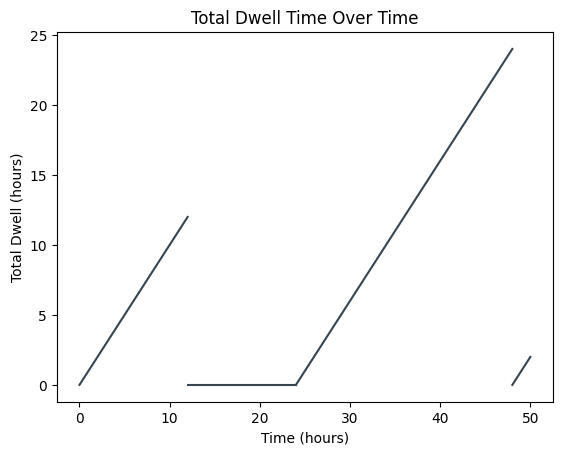

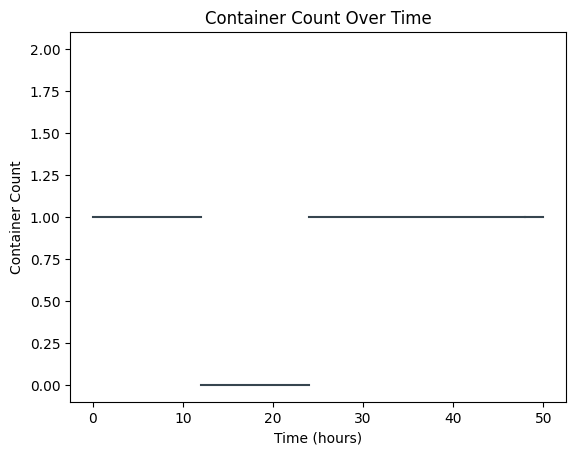

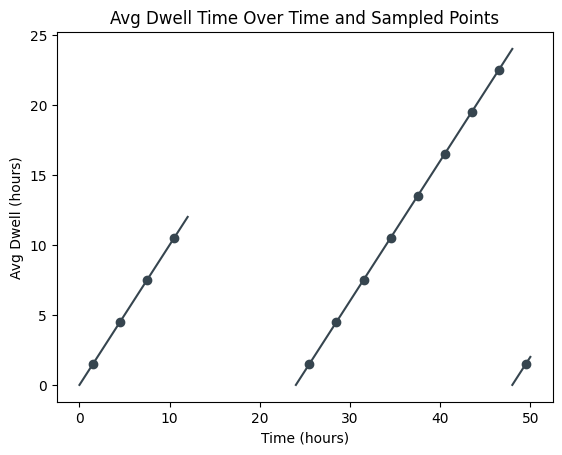

    SamplingTime  SampleDwell
0            1.5          1.5
5            4.5          4.5
10           7.5          7.5
15          10.5         10.5
21          13.5          NaN
26          16.5          NaN
31          19.5          NaN
36          22.5          NaN
42          25.5          1.5
47          28.5          4.5
52          31.5          7.5
57          34.5         10.5
62          37.5         13.5
67          40.5         16.5
72          43.5         19.5
77          46.5         22.5
84          49.5          1.5
    SamplingTime  SampleDwell  DayIndex  TranslatedTime  TranslatedQuotient  \
0            1.5          1.5         1           -22.5                   0   
1            4.5          4.5         1           -19.5                   0   
2            7.5          7.5         1           -16.5                   0   
3           10.5         10.5         1           -13.5                   0   
4           13.5          0.0         1           -10.5          

(np.float64(5.027777777777778),
    Day  Total_Areas  Total_Duration  Record_Count  avg dwell
 0    1         72.0            24.0             2   3.000000
 1    2        288.0            24.0             2  12.000000
 2    3          2.0             2.0             3   0.083333,
 np.float64(5.027777777777778),
 np.float64(7.147058823529412),
    Day  Avg Dwell
 0    1        3.0
 1    2       12.0
 2    3        1.5,
 np.float64(5.5),
 np.float64(9.526315789473685),
      Avg_dwell_term  Avg_box_count_term  Division
 Day                                              
 1          3.000000            0.500000       6.0
 2         12.000000            1.000000      12.0
 3          0.083333            0.083333       1.0,
 np.float64(6.333333333333333),
 np.float64(12.666666666666666),
    Day  AvgDwell
 0    1      12.0
 1    2      24.0
 2    3       2.0,
 np.float64(12.666666666666666))

In [341]:
dwell_times(box_schedules, sample_gap)

Need to proof ratio and Mainsail results with second example. Then test with additional examples.